In [5]:
import numpy
import xarray
import matplotlib.pyplot as plt
import warnings
import os
from xarray.coders import CFDatetimeCoder

In [7]:
coder = CFDatetimeCoder(use_cftime=True)
ds = xarray.open_dataset('/Volumes/LaCie/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon'+\
                       '/thetao/gn/v20190627/thetao_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-189912.nc',
                       decode_times=coder)

ds = ds.drop_vars('time_bnds')
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

In [9]:
ds

<xarray.Dataset> Size: 21GB
Dimensions:             (time: 600, lev: 75, bnds: 2, j: 330, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) object 5kB 1850-01-16 00:00:00 ... 1899-12-16 ...
  * lev                 (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 324 325 326 327 328 329
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    lat                 (j, i) float32 475kB ...
    lon                 (j, i) float32 475kB ...
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (lev, bnds) float64 1kB ...
    vertices_latitude   (j, i, vertices) float32 2MB ...
    vertices_longitude  (j, i, vertices) float32 2MB ...
    thetao              (time, lev, j, i) float32 21GB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-24T12:36:14Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/747722c3-3f98-4bfc-9024-7bc9c597bd82

In [ ]:
def compute_yearly_mean(inFileName, outFileName):
    # crop to below 48 S and take annual mean over the data
    if os.path.exists(outFileName):
        return
    print('{} to {}'.format(inFileName, outFileName))

    ds = xarray.open_dataset(inFileName)
    ds = ds.rename({'longitude': 'lon',
                    'latitude': 'lat',
                    'vertices_longitude': 'lon_vertices',
                    'vertices_latitude': 'lat_vertices'})

    ds = ds.drop_vars('time_bnds')

    # crop to Southern Ocean
    minLat = ds.lat.min(dim='i')
    mask = minLat <= -48.
    yIndices = numpy.nonzero(mask.values)[0]
    ds = ds.isel(j=yIndices)

    for coord in ['lev_bnds', 'lon_vertices', 'lat_vertices']:
        ds.coords[coord] = ds[coord]

    # annual mean
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        ds = ds.groupby('time.year').mean('time', keep_attrs=True)


    #return ds
    # convert back to CF-compliant time
    ds = ds.rename({'year': 'time'})
    ds['time'] = 365.0*ds.time
    ds['time'].attrs['bounds'] = "time_bnds"
    ds['time'].attrs['units'] = "days since 0000-01-01 00:00:00"
    ds['time'].attrs['calendar'] = "noleap"
    ds['time'].attrs['axis'] = "T"
    ds['time'].attrs['long_name'] = "time"
    ds['time'].attrs['standard_name'] = "time"

    timeBounds = numpy.zeros((ds.sizes['time'], ds.sizes['bnds']))
    timeBounds[:, 0] = ds.time.values
    timeBounds[:, 1] = ds.time.values + 365
    ds['time_bnds'] = (('time', 'bnds'), timeBounds)

    ds['time_bnds'].attrs['units'] = "days since 0000-01-01 00:00:00"
    ds['time_bnds'].attrs['calendar'] = "noleap"
    
    time_coder = xarray.coders.CFDatetimeCoder(use_cftime=True)
    time_var = ds.variables['time']
    bnds_var = ds.variables['time_bnds']
    decoded_time = time_coder.decode(time_var, time_var.attrs)
    decoded_bnds = time_coder.decode(bnds_var, bnds_var.attrs)
    ds = ds.assign_coords(time=decoded_time, time_bnds=decoded_bnds)

    # ds = xarray.decode_cf(ds, use_cftime=True)
    
    return ds
    encoding = {'time': {'units': 'days since 0000-01-01'}}
    #ds.to_netcdf(outFileName, encoding=encoding)

In [87]:
inFileName = '/Volumes/LaCie/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon'+\
                       '/thetao/gn/v20190627/thetao_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-189912.nc'
ds = compute_yearly_mean(inFileName, 'test.nc')

/Volumes/LaCie/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon/thetao/gn/v20190627/thetao_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-189912.nc to test.nc


In [88]:
ds.time_bnds.values

array([[cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1851, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1851, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1852, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1852, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1853, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1853, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1854, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1854, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1855, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1855, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1856, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1856, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.Date

In [85]:
ds.time_bnds.values

array([[cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1851, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1851, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1852, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1852, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1853, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1853, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1854, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1854, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1855, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1855, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1856, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1856, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.Date

In [81]:
ds.time_bnds.values

array([[675250., 675615.],
       [675615., 675980.],
       [675980., 676345.],
       [676345., 676710.],
       [676710., 677075.],
       [677075., 677440.],
       [677440., 677805.],
       [677805., 678170.],
       [678170., 678535.],
       [678535., 678900.],
       [678900., 679265.],
       [679265., 679630.],
       [679630., 679995.],
       [679995., 680360.],
       [680360., 680725.],
       [680725., 681090.],
       [681090., 681455.],
       [681455., 681820.],
       [681820., 682185.],
       [682185., 682550.],
       [682550., 682915.],
       [682915., 683280.],
       [683280., 683645.],
       [683645., 684010.],
       [684010., 684375.],
       [684375., 684740.],
       [684740., 685105.],
       [685105., 685470.],
       [685470., 685835.],
       [685835., 686200.],
       [686200., 686565.],
       [686565., 686930.],
       [686930., 687295.],
       [687295., 687660.],
       [687660., 688025.],
       [688025., 688390.],
       [688390., 688755.],
 

In [56]:
ds = ds.rename({'year': 'time'})
ds['time'] = 365.0*ds.time
ds

<xarray.Dataset> Size: 628MB
Dimensions:       (time: 50, lev: 75, j: 116, i: 360, bnds: 2, vertices: 4)
Coordinates:
  * lev           (lev) float64 600B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bnds      (lev, bnds) float64 1kB 0.0 1.024 1.024 ... 5.8e+03 6.004e+03
  * j             (j) int32 464B 0 1 2 3 4 5 6 7 ... 109 110 111 112 113 114 115
  * i             (i) int32 1kB 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
    lat           (j, i) float32 167kB -84.11 -84.11 -84.11 ... -48.09 -48.09
    lon           (j, i) float32 167kB 73.5 74.5 75.5 76.5 ... 70.5 71.5 72.5
    lat_vertices  (j, i, vertices) float32 668kB -84.16 -84.16 ... -47.76 -47.76
    lon_vertices  (j, i, vertices) float32 668kB 73.0 74.0 74.0 ... 73.0 72.0
  * time          (time) float64 400B 6.752e+05 6.756e+05 ... 6.931e+05
Dimensions without coordinates: bnds, vertices
Data variables:
    thetao        (time, lev, j, i) float32 626MB nan nan nan ... nan nan nan
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-24T12:36:14Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/747722c3-3f98-4bfc-9024-7bc9c597bd82

In [59]:
ds.variables["time"].attrs["units"] = "days since 0000-01-01 00:00:00"
ds.variables["time"].attrs["calendar"] = "noleap"  # or "noleap", "360_day", etc

ds.variables['time'].attrs

{'units': 'days since 0000-01-01 00:00:00', 'calendar': 'noleap'}

In [60]:
time_var = ds.variables["time"]
coder = CFDatetimeCoder(use_cftime=True)
decoded_time = coder.decode(time_var, time_var.attrs)


In [69]:
ds = ds.assign_coords(time=decoded_time)
ds.time

<xarray.DataArray 'time' (time: 50)> Size: 400B
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1851, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1852, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1853, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1854, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1855, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1856, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1857, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1858, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1859, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1860, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1861, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1862, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1863, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1864, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1865, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1866, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1867, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1868, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1869, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1870, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1871, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1872, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1873, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1874, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1875, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1876, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1877, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1878, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1879, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1880, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1881, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1882, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1883, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1884, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1885, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1886, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1887, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1888, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1889, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1890, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1891, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1892, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1893, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1894, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1895, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1896, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1897, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1898, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1899, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 400B 1850-01-01 00:00:00 ... 1899-01-01 00:00:00

In [67]:
ds['time'].values

array([675250.0, 675615.0, 675980.0, 676345.0, 676710.0, 677075.0,
       677440.0, 677805.0, 678170.0, 678535.0, 678900.0, 679265.0,
       679630.0, 679995.0, 680360.0, 680725.0, 681090.0, 681455.0,
       681820.0, 682185.0, 682550.0, 682915.0, 683280.0, 683645.0,
       684010.0, 684375.0, 684740.0, 685105.0, 685470.0, 685835.0,
       686200.0, 686565.0, 686930.0, 687295.0, 687660.0, 688025.0,
       688390.0, 688755.0, 689120.0, 689485.0, 689850.0, 690215.0,
       690580.0, 690945.0, 691310.0, 691675.0, 692040.0, 692405.0,
       692770.0, 693135.0], dtype=object)

In [5]:
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
ds['time'] = time_coder.decode(ds['time'], ds['time'].attrs)

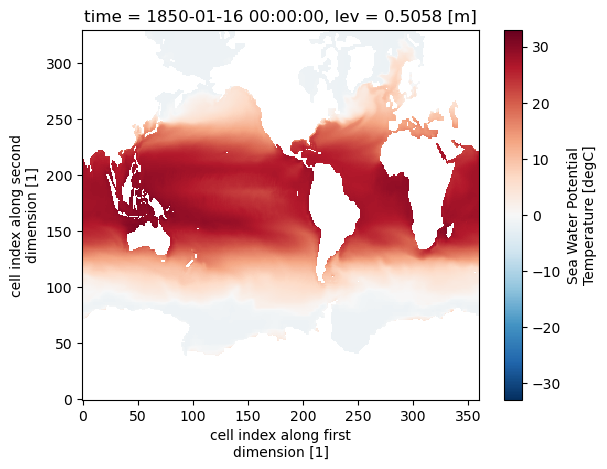

In [25]:
ds.isel(lev=0, time=0).thetao.plot()

In [26]:
minLat = ds.lat.min(dim='i')
minLat

<xarray.DataArray 'lat' (j: 330)>
array([-85.63117   , -85.472984  , -85.31397   , -85.15413   ,
       -84.99345   , -84.831924  , -84.66953   , -84.50627   ,
       -84.3421    , -84.17702   , -84.01097   , -83.84397   ,
       -83.67616   , -83.50729   , -83.337326  , -83.166214  ,
       -82.99392   , -82.82039   , -82.645584  , -82.469444  ,
       -82.29193   , -82.11298   , -81.93266   , -81.75085   ,
       -81.56742   , -81.382324  , -81.195496  , -81.00687   ,
       -80.81638   , -80.62398   , -80.42959   , -80.23315   ,
       -80.03458   , -79.8339    , -79.63099   , -79.425735  ,
       -79.21808   , -79.00794   , -78.79526   , -78.57995   ,
       -78.361946  , -78.141174  , -77.91756   , -77.691025  ,
       -77.461494  , -77.228905  , -76.99319   , -76.754265  ,
       -76.51203   , -76.26642   , -76.01734   , -75.764725  ,
       -75.50849   , -75.24855   , -74.98483   , -74.717255  ,
       -74.44573   , -74.17018   , -73.89052   , -73.60666   ,
       -73.31853   , -73.02715   , -72.73279   , -72.43347   ,
       -72.129135  , -71.8197    , -71.5051    , -71.185234  ,
       -70.86005   , -70.52946   , -70.193375  , -69.85174   ,
       -69.50445   , -69.151436  , -68.792625  , -68.427925  ,
       -68.05725   , -67.680534  , -67.29768   , -66.90862   ,
...
        41.515827  ,  41.888973  ,  42.24653   ,  42.589024  ,
        42.916992  ,  43.23097   ,  43.531467  ,  43.81901   ,
        44.094097  ,  44.357224  ,  44.60887   ,  44.84951   ,
        45.079597  ,  45.299576  ,  45.509876  ,  45.710915  ,
        45.90309   ,  46.086792  ,  46.26239   ,  46.430252  ,
        46.590717  ,  46.744118  ,  46.890778  ,  47.031     ,
        47.16508   ,  47.293297  ,  47.415928  ,  47.533222  ,
        47.645435  ,  47.752796  ,  47.85554   ,  47.953876  ,
        48.048016  ,  48.138157  ,  48.224483  ,  48.307182  ,
        48.386425  ,  48.46237   ,  48.535187  ,  48.605015  ,
        48.672005  ,  48.73629   ,  48.798     ,  48.857265  ,
        48.914204  ,  48.968925  ,  49.02155   ,  49.07217   ,
        49.120895  ,  49.16782   ,  49.21303   ,  49.25663   ,
        49.29869   ,  49.3393    ,  49.378536  ,  49.416485  ,
        49.453213  ,  49.4888    ,  49.523323  ,  49.556847  ,
        49.58945   ,  49.621204  ,  49.652187  ,  49.682476  ,
        49.712143  ,  49.741272  ,  49.76993   ,  49.798187  ,
        49.82608   ,  49.85361   ,  49.880688  ,  49.90708   ,
        49.932354  ,  49.955803  ,  49.97647   ,  49.99324   ,
        50.00502   ,  50.01094   ], dtype=float32)
Coordinates:
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328 329

In [27]:
mask = minLat <= -48.
yIndices = np.nonzero(mask.values)[0]
yIndices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115])

In [28]:
ds = ds.isel(j=yIndices)
ds

<xarray.Dataset>
Dimensions:             (time: 600, lev: 75, bnds: 2, j: 116, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) object 1850-01-16 00:00:00 ... 1899-12-16 00:0...
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j                   (j) int32 0 1 2 3 4 5 6 ... 109 110 111 112 113 114 115
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    lat                 (j, i) float32 -84.11 -84.11 -84.11 ... -48.09 -48.09
    lon                 (j, i) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    lev_bnds            (lev, bnds) float64 ...
    vertices_latitude   (j, i, vertices) float32 ...
    vertices_longitude  (j, i, vertices) float32 ...
    thetao              (time, lev, j, i) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-24T12:36:14Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/747722c3-3f98-4bfc-9024-7bc9c597bd82

In [29]:
for coord in ['lev_bnds', 'vertices_longitude', 'vertices_latitude']:
    ds.coords[coord] = ds[coord]

ds

<xarray.Dataset>
Dimensions:             (time: 600, lev: 75, bnds: 2, j: 116, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) object 1850-01-16 00:00:00 ... 1899-12-16 00:0...
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bnds            (lev, bnds) float64 ...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 109 110 111 112 113 114 115
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    lat                 (j, i) float32 -84.11 -84.11 -84.11 ... -48.09 -48.09
    lon                 (j, i) float32 ...
    vertices_latitude   (j, i, vertices) float32 ...
    vertices_longitude  (j, i, vertices) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    thetao              (time, lev, j, i) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-24T12:36:14Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/747722c3-3f98-4bfc-9024-7bc9c597bd82

In [30]:
# annual mean
ds = ds.groupby('time.year').mean('time', keep_attrs=True)
ds

<xarray.Dataset>
Dimensions:             (lev: 75, bnds: 2, j: 116, i: 360, vertices: 4, year: 50)
Coordinates:
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bnds            (lev, bnds) float64 0.0 1.024 ... 5.8e+03 6.004e+03
  * j                   (j) int32 0 1 2 3 4 5 6 ... 109 110 111 112 113 114 115
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    lat                 (j, i) float32 -84.11 -84.11 -84.11 ... -48.09 -48.09
    lon                 (j, i) float32 73.5 74.5 75.5 76.5 ... 70.5 71.5 72.5
    vertices_latitude   (j, i, vertices) float32 -84.16 -84.16 ... -47.76 -47.76
    vertices_longitude  (j, i, vertices) float32 73.0 74.0 74.0 ... 73.0 72.0
  * year                (year) int64 1850 1851 1852 1853 ... 1896 1897 1898 1899
Dimensions without coordinates: bnds, vertices
Data variables:
    thetao              (year, lev, j, i) float32 nan nan nan ... nan nan nan
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2019-06-24T12:36:14Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/747722c3-3f98-4bfc-9024-7bc9c597bd82

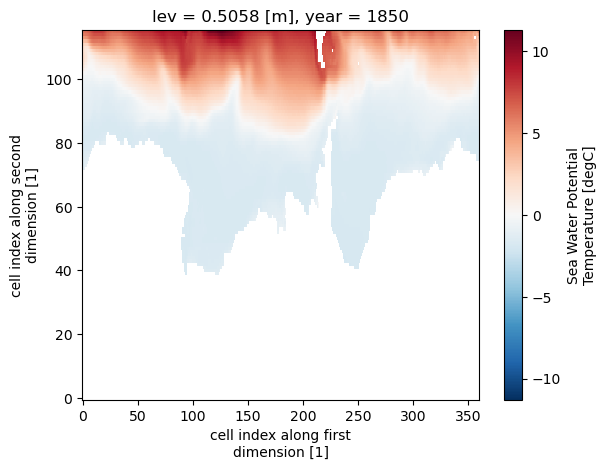

In [22]:
ds.isel(year=0, lev=0).thetao.plot()

In [2]:
file = xarray.open_dataset('/Users/jonniebarnsley/Downloads/UKESM1-0-LL_temperature_8km_x_60m.nc')
file

<xarray.Dataset> Size: 148MB
Dimensions:      (x: 761, y: 761, time: 1, z: 30, nbounds: 2)
Coordinates:
  * x            (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * y            (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
    lat          (y, x) float64 5MB ...
    lon          (y, x) float64 5MB ...
  * time         (time) object 8B 2000-01-01 00:00:00
  * z            (z) float64 240B -30.0 -90.0 -150.0 ... -1.71e+03 -1.77e+03
    z_bnds       (z, nbounds) float64 480B ...
Dimensions without coordinates: nbounds
Data variables:
    temperature  (time, z, y, x) float64 139MB ...

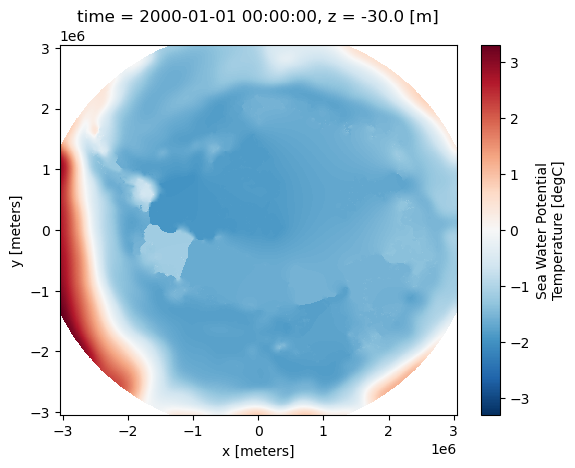

In [5]:
file.isel(time=0, z=0).temperature.plot()

In [6]:
len(file.z)

30

In [7]:
import xarray as xr
from xarray.coders import CFDatetimeCoder

coder = CFDatetimeCoder(use_cftime=True)
nico2100 = xr.open_dataset('/Users/jonniebarnsley/Downloads/nico_2100.nc', decode_times=coder)
xyla2100 = xr.open_dataset('/Users/jonniebarnsley/Downloads/UKESM1-0-LL_ssp126_thermal_forcing_8km_x_60m_2100.nc', decode_times=coder)

nico2300 = xr.open_dataset('/Users/jonniebarnsley/Downloads/nico_2300.nc', decode_times=coder)
xyla2300 = xr.open_dataset('/Users/jonniebarnsley/Downloads/UKESM1-0-LL_ssp126_thermal_forcing_8km_x_60m_2300.nc', decode_times=coder)

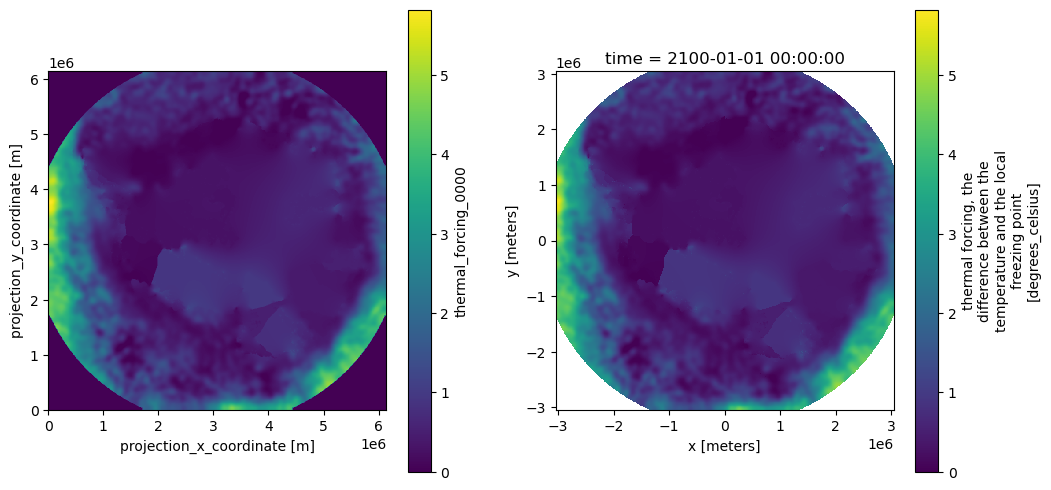

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

nico2100.thermal_forcing_0000.plot(ax=ax[0])
xyla2100.thermal_forcing0000.plot(ax=ax[1])

for a in ax:
    a.set_aspect('equal')

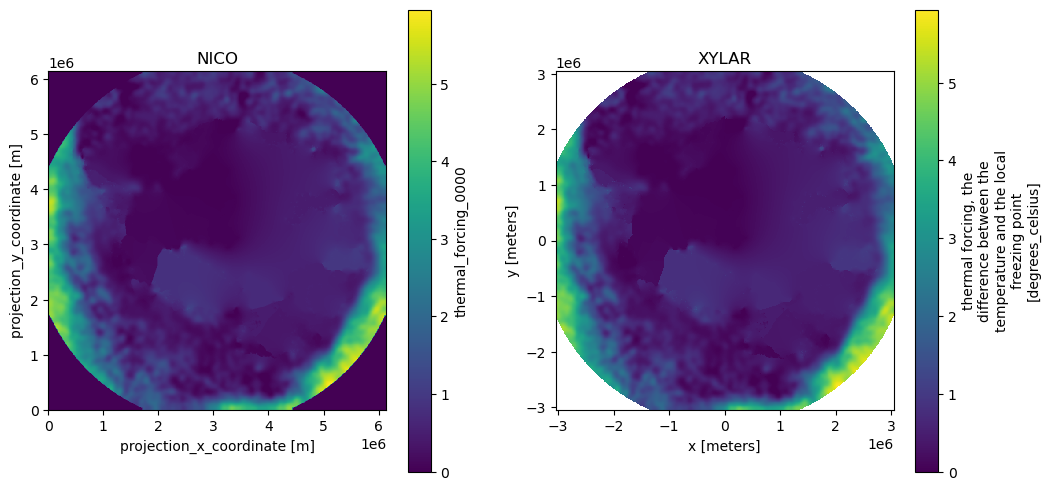

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

nico2300.thermal_forcing_0000.plot(ax=ax[0])
xyla2300.thermal_forcing0000.plot(ax=ax[1])

ax[0].set_title('NICO')
ax[1].set_title('XYLAR')

for a in ax:
    a.set_aspect('equal')